# 05 - CNN Baseline

In questo notebook addestriamo un **modello CNN baseline** per la classificazione delle immagini di rifiuti.

**Obiettivi:**
- usare la pipeline `tf.data` definita in `src`
- addestrare una CNN semplice come baseline
- valutare le prestazioni su validation e test set

Questo modello rappresenta il primo vero modello “image-based” del progetto,
da confrontare con la baseline lineare.

#### 0) Import librerie e moduli progetto e setup path

Effettuo le seguenti operazioni a partire da:
- `src/garbagecls/db.py`
- `src/garbagecls/paths.py`
- `src/garbagecls/dataset.py`

In [1]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name.lower() == "notebooks" else Path.cwd()
sys.path.append(str(ROOT / "src"))

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from garbagecls.db import load_env, read_images_df, split_dfs
from garbagecls.dataset import build_label_maps, make_dataset


#### 1) Caricamento dati da DB e creazione dei 3 dataset

In [ ]:
load_env()

df = read_images_df(source="raw_flat")
df_train, df_val, df_test = split_dfs(df)

label2id, id2label = build_label_maps(df["label"].unique())
num_classes = len(label2id)

for d in (df_train, df_val, df_test):
    d["label_id"] = d["label"].map(label2id).astype("int32")

IMG_SIZE = (384, 512)
BATCH_SIZE = 32
SEED = 42

train_ds = make_dataset(
    df_train, training=True,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=True
)

val_ds = make_dataset(
    df_val, training=False,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=False
)

test_ds = make_dataset(
    df_test, training=False,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=False
)

num_classes

print(train_ds.element_spec)


c:\Users\simon\Documents\VSC\Progetto-Data-Science\src\garbagecls\db.py:77: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(base_query, conn, params=params if params else None)


6

#### 2) Definizione CNN baseline

In [4]:
model = keras.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),

    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 382, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 191, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 189, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 94, 126, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 92, 124, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 46, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 365056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    46,727,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,821,318 (178.61 MB)

 Trainable params: 46,821,318 (178.61 MB)

 Non-trainable params: 0 (0.00 B)

#### 3) Compilazione e training

In [5]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), # Adam optimizer with a learning rate of 0.001 
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.3133 - loss: 1.9806 - val_accuracy: 0.4248 - val_loss: 1.4708
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.4519 - loss: 1.3280 - val_accuracy: 0.5383 - val_loss: 1.1740
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.5498 - loss: 1.1775 - val_accuracy: 0.6069 - val_loss: 1.1083
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.5843 - loss: 1.0594 - val_accuracy: 0.6042 - val_loss: 1.0856
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.6250 - loss: 0.9972 - val_accuracy: 0.6174 - val_loss: 1.1670
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6669 - loss: 0.9214 - val_accuracy: 0.6385 - val_loss: 1.0236
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.6324 - loss: 0.9817 - val_accuracy: 0.5778 - val_loss: 1.2657
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.7031 - loss: 0.8207 - val_accuracy: 0.6227 - v

#### 4) Valutazione sul test set

In [6]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 321ms/step - accuracy: 0.5711 - loss: 1.2304
Test accuracy: 0.5711


#### 5) Curve di training

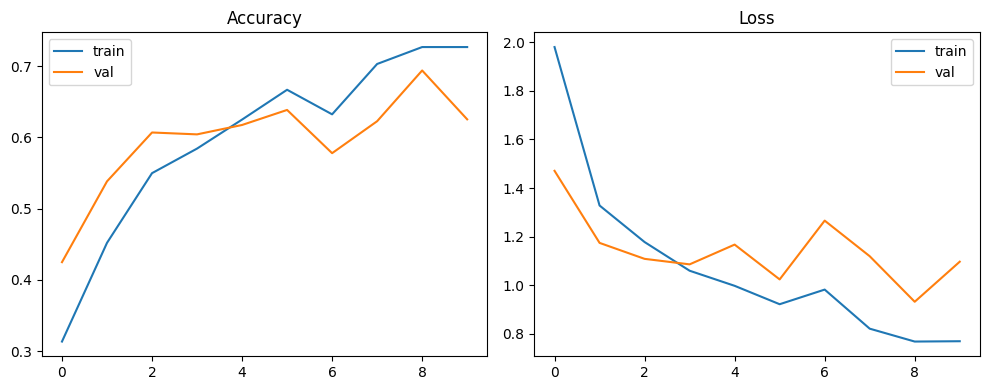

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()


## Considerazioni

- La CNN sfrutta la struttura spaziale delle immagini, a differenza della baseline lineare.
- Le prestazioni risultano significativamente migliori rispetto alla logistic regression.
- Questo modello costituisce un punto di partenza per:
  - architetture più profonde
  - transfer learning (es. MobileNet, ResNet)
